# This is a collaborative work of Trang Nguyen and Jacob Puthipiroj

# Table of Contents
1. [Introduction] (#introduction)
    1. [Qualitative Responses] (#qualitative)
    2. [Latent Dirichlet Allocation] (#lda)
2. [Importing] (#import)
3. [Data Pre-processing] (#processing)
4. [LDA Functions] (#functions)
5. [Results] (#results)
    1. [Why is this your preferred mode?] (#whymode)
        1. [Why is 'recorded' your preferred mode?] (#recorded)
        2. [Why is 'live' your preferred mode?] (#live)
        3. [Why is 'upload' your preferred mode?] (#upload)
        4. [Why is 'chat' your preferred mode?] (#chat)
    2. [Why do you prefer online or in-person courses?] (#whypreference)
        1. [Why do you prefer in-person courses?] (#inperson)
        2. [Why do you prefer online courses?] (#online)
    3. [What would you change about online classes?] (#remotechange)
    4. [What would you change about in-person classes?] (#inpersonchange)



# Introduction <a name='introduction'></a>

## Topic Modelling for Qualitative Responses <a name='qualitative'></a>

In this notebook, we use LDA for identify topics mentioned in the qualitative responses for the following 4 questions:

1. Why is this your preferred mode? (As a follow-up to the question 'What is your preferred mode of teaching for online courses.')
    - Recorded
    - Live
    - Uploaded Materials
    - Chat
2. Why do you prefer online or in-person courses? (As a follow-up to the question 'Do you prefer online or in person courses?') 
    - In-Person
    - Online
3. If you could change one thing about the way your online classes are designed, what would you change? Why?
4. If you could change one thing about the way your in-person classes are designed, what would you change? Why?

Note: Save output to CSV

Note: LDAMallet might be better than gensim's LDA, need to try this at some point

## What is LDA and how is it relevant? <a name='lda'></a>
Latent dirichlet allocation attempts to explain a bag of words as parts of unobserved groups. In other words, sentences are thought to be generated from an underlying topic. Once the model is built, then, LDA can be used to identify what the topics are.

In context, LDA is used to encode the various types of responses to a qualitative question (e.g. why is your preferred mode of learning recorded lectures?) as part of a topic. Two such topics could be something of the form:

- (0,
  '0.035*"pause" + 0.033*"watch" + 0.031*"time" + 0.025*"go" + 0.023*"back" + '
  '0.020*"notes" + 0.020*"lecture" + 0.019*"want" + 0.019*"take" + '
  '0.016*"understand"')
- (1,
  '0.038*"time" + 0.026*"pace" + 0.024*"live" + 0.022*"lectures" + '
  '0.018*"classes" + 0.017*"recorded" + 0.017*"work" + 0.012*"material" + '
  '0.012*"zoom" + 0.010*"learn"')

Topics must be interpreted, but it should be clear that:

- the first response refers generally to the ability to 'pause' and 'watch' 'lectures' in their own 'time', 'go' 'back' to previously material so they can better 'understand' it.
- the second response refers generally to the ability to control the 'pace' of 'recorded' 'lectures', unlike 'live' 'classes', as well as the ability to take class at convenient 'times' that don't interfere with 'work'

Topic interpretation is often subjective and difficult. To help, we can look at examples:
- (1) Because you can watch and pause at your own leisure, when distracted you can pause
- (1) It's easier to understand and we can watch/listen to the material several times.
- (1) So I can pause it and take good notes
- (2) I can do them at any time
- (2) It is the most efficient way.
- (2) I can work through it at my own speed

From reading the responses, there may be more or less topics than the model suggests. The second reason seems to actually be referring to two separate reasons for preferring recorded lectures: the ability to control the speed of the material, and the ability to learn material at a convenient schedule.


# Importing <a name='import'></a>

In [ ]:
!pip install gensim
!pip install nltk

import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt

import string
import gensim
from gensim import corpora

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords 

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = stopwords.words('english')
lemma = WordNetLemmatizer()

     |████████████████████████████████| 1.4 MB 3.8 MB/s eta 0:00:01     |█████████████████████████████▊  | 1.3 MB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 82 kB 575 kB/s  eta 0:00:01
     |████████████████████████████████| 661 kB 13.2 MB/s eta 0:00:01
     |████████████████████████████████| 66 kB 1.7 MB/s eta 0:00:011
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434677 sha256=24d58985bc7c2dca2a8ff5847861bbfb71ef616b05f53338d2c47d74506a82f3
  Stored in directory: /home/jovyan/.cache/pip/wheels/45/6c/46/a1865e7ba706b3817f5d1b2ff7ce8996aabdd0d03d47ba0266
Successfully built nltk
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Data Pre-processing <a name='processing'></a>

For each column of responses, we:
- Drop NAs
- Take lowercase
- Lemmatize
- Remove stopwords, numbers, special characters

In [ ]:
df = pd.read_csv('processed_data.csv')
df = df[df.level.eq("Undergraduate (studying for associates or bachelors degrees)")]
df = df.reset_index()

why_mode = df['why_mode'].dropna() # Why is this your preferred mode? 
why_preference = df['why_preference'].dropna() # Why do you prefer online or in-person courses? 
remote_changes = df['remote_changes'].dropna() # If you could change one thing about the way your online classes are designed, what would you change? Why?
prior_changes = df['prior_changes'].dropna() # If you could change one thing about the way your in-person classes are designed, what would you change? Why?

In [ ]:
def remove_stopwords(sen):
    return ' '.join([i for i in sen if i not in stop_words])

def process_data(column):
    # take only lowercased words
    sentences = column.str.replace('[^a-zA-Z]', ' ').str.lower().dropna()

    # lemmatize
    lsentences = [lemma.lemmatize(sentence) for sentence in sentences]

    # remove stopwords
    return [remove_stopwords(sentence.split()) for sentence in lsentences]


columnlist = [process_data(column) for column \
    in [why_mode, why_preference, remote_changes, prior_changes]]


# LDA Model Functions <a name='functions'></a>

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

def optimalmodel(column, passes = 50, start = 2, stop = 40, step = 4, plot = True):
    # make each sentence a list of strings
    columnwords = [sentence.split() for sentence in column]

    # build a term dictionary which indexes all words from all sentences in column
    dictionary = corpora.Dictionary(columnwords)

    # convert all sentences to indexed words in the dictionary
    corpus = [dictionary.doc2bow(sentence) for sentence in columnwords]

    coherence_list = []
    model_list = []

    # loop over models for grid search
    for num_topics in range(start, stop, step):
        model = gensim.models.ldamodel.LdaModel(corpus, id2word = dictionary, num_topics=num_topics, passes=passes)     
        coherence_score = CoherenceModel(model=model, texts=columnwords, dictionary=dictionary, coherence='c_v').get_coherence()

        model_list.append(model)
        coherence_list.append(coherence_score)

    optimal_model = model_list[np.asarray(coherence_list).argmax()]
    optimal_num = list(range(start,stop,step))[np.asarray(coherence_list).argmax()]

    print('There are optimally', optimal_num, 'topics')
    if plot:
        plt.plot(list(range(start, stop, step)), coherence_list)
        plt.xlabel("Num Topics")
        plt.ylabel("Coherence")
        plt.show()

    return optimal_model, columnwords, dictionary, corpus

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break

    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    return pd.concat([sent_topics_df, pd.Series(texts)], axis=1).dropna()


def representative(df):
    df = df.reset_index()
    df.columns = ['Sentence_No', 'Dominant_Topic', 'Percent_Contribution', 'Keywords', 'Text']


    topics_sorted = pd.DataFrame()
    sent_topics_outdf_grpd = df.groupby('Dominant_Topic')

    for i, grp in sent_topics_outdf_grpd:
        topics_sorted = pd.concat([topics_sorted, grp.sort_values(['Percent_Contribution'], ascending=[0]).head(5)], axis=0)


    return topics_sorted.reset_index(drop = True, inplace = False)


# Results <a name='results'></a>

## Why is This Your Preferred Mode? <a name='whymode'></a>

### Why is 'recorded' your preferred mode? <a name='recorded'></a>

There are optimally 2 topics


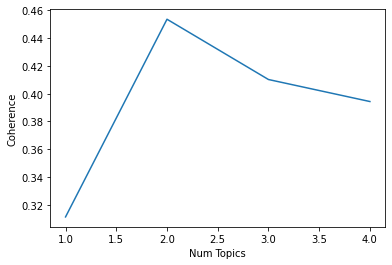

[(0,
  '0.035*"pause" + 0.033*"watch" + 0.031*"time" + 0.025*"go" + 0.023*"back" + '
  '0.020*"notes" + 0.020*"lecture" + 0.019*"want" + 0.019*"take" + '
  '0.016*"understand"'),
 (1,
  '0.038*"time" + 0.026*"pace" + 0.024*"live" + 0.022*"lectures" + '
  '0.018*"classes" + 0.017*"recorded" + 0.017*"work" + 0.012*"material" + '
  '0.012*"zoom" + 0.010*"learn"')]


,Sentence_No,Dominant_Topic,Percent_Contribution,Keywords,Text
0,623,0.0,0.9744,"pause, watch, time, go, back, notes, lecture, ...",Recorded lectures
1,873,0.0,0.9740,"pause, watch, time, go, back, notes, lecture, ...",Because you can watch and pause at your own le...
2,430,0.0,0.9682,"pause, watch, time, go, back, notes, lecture, ...",So I can pause it and take good notes
3,570,0.0,0.9670,"pause, watch, time, go, back, notes, lecture, ...",It's easier to understand and we can watch/lis...
4,1160,0.0,0.9633,"pause, watch, time, go, back, notes, lecture, ...",It’s a lot more organized in comparison to zoo...
5,1070,1.0,0.9810,"time, pace, live, lectures, classes, recorded,...",I can do them at any time
6,840,1.0,0.9787,"time, pace, live, lectures, classes, recorded,...","I can adapt the content to my desired speed, p..."
7,1128,1.0,0.9765,"time, pace, live, lectures, classes, recorded,...",It is the most efficient way.
8,74,1.0,0.9730,"time, pace, live, lectures, classes, recorded,...",Can rewind
9,425,1.0,0.9696,"time, pace, live, lectures, classes, recorded,...",I can work through it at my own speed


In [ ]:
i = 'recorded'

why_for_i = df[df['preferred_mode'] == i]['why_mode']
optimal_model, columnwords, dictionary, corpus = optimalmodel(process_data(why_for_i), passes = 80, start = 1, stop = 5, step = 1)
df_why_mode = format_topics_sentences(optimal_model, corpus, why_for_i)
pprint(optimal_model.print_topics())
representative(df_why_mode)

### Why is 'live' your preferred mode? <a name='live'></a>

There are optimally 4 topics


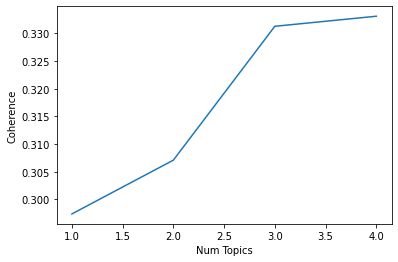

[(0,
  '0.030*"lectures" + 0.029*"recorded" + 0.028*"like" + 0.023*"class" + '
  '0.022*"get" + 0.020*"feel" + 0.020*"live" + 0.018*"actually" + '
  '0.015*"lecture" + 0.015*"time"'),
 (1,
  '0.103*"questions" + 0.087*"ask" + 0.029*"live" + 0.023*"get" + '
  '0.023*"interaction" + 0.020*"time" + 0.019*"allows" + 0.017*"classes" + '
  '0.017*"easier" + 0.015*"interact"'),
 (2,
  '0.034*"students" + 0.026*"people" + 0.024*"interact" + 0.022*"engage" + '
  '0.021*"easier" + 0.021*"interaction" + 0.020*"able" + 0.017*"discuss" + '
  '0.014*"see" + 0.013*"find"'),
 (3,
  '0.053*"interactive" + 0.034*"face" + 0.028*"engaging" + 0.021*"class" + '
  '0.020*"like" + 0.018*"closest" + 0.016*"learning" + 0.016*"classes" + '
  '0.015*"structure" + 0.014*"normal"')]


,Sentence_No,Dominant_Topic,Percent_Contribution,Keywords,Text
0,1517,0.0,0.9666,"lectures, recorded, like, class, get, feel, li...",Being able to interact with professors makes a...
1,2070,0.0,0.9628,"lectures, recorded, like, class, get, feel, li...",keeps me accountable and helps structuring my ...
2,947,0.0,0.9590,"lectures, recorded, like, class, get, feel, li...",It is a million times more engaging than a rec...
3,1077,0.0,0.9517,"lectures, recorded, like, class, get, feel, li...",Feels more like an actual classroom
4,2274,0.0,0.9499,"lectures, recorded, like, class, get, feel, li...",Easy to ask questions
5,1752,1.0,0.9455,"questions, ask, live, get, interaction, time, ...",As it is interactive and isn’t passive so you ...
6,25,1.0,0.9415,"questions, ask, live, get, interaction, time, ...",Get an instant reply from lecturers
7,2049,1.0,0.9349,"questions, ask, live, get, interaction, time, ...",It’s almost as good as real teaching! You can ...
8,1988,1.0,0.9292,"questions, ask, live, get, interaction, time, ...",Discussion of content
9,2157,1.0,0.9287,"questions, ask, live, get, interaction, time, ...",Interactive\n


In [ ]:
i = 'live'

why_for_i = df[df['preferred_mode'] == i]['why_mode']
optimal_model, columnwords, dictionary, corpus = optimalmodel(process_data(why_for_i), passes = 80, start = 1, stop = 5, step = 1)
df_why_mode = format_topics_sentences(optimal_model, corpus, why_for_i)
pprint(optimal_model.print_topics())
representative(df_why_mode)

### Why is 'upload' your preferred mode? <a name='upload'></a>

There are optimally 4 topics


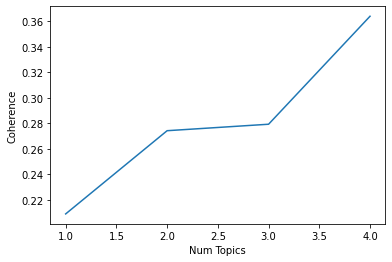

[(0,
  '0.023*"classes" + 0.021*"live" + 0.018*"time" + 0.018*"like" + '
  '0.014*"materials" + 0.014*"online" + 0.013*"find" + 0.012*"lectures" + '
  '0.011*"feel" + 0.011*"information"'),
 (1,
  '0.071*"work" + 0.064*"time" + 0.044*"pace" + 0.020*"allows" + '
  '0.015*"material" + 0.015*"easier" + 0.011*"go" + 0.010*"able" + '
  '0.009*"classes" + 0.008*"like"'),
 (2,
  '0.019*"notes" + 0.018*"back" + 0.015*"pace" + 0.013*"easier" + 0.013*"time" '
  '+ 0.012*"materials" + 0.011*"zoom" + 0.010*"go" + 0.010*"lecture" + '
  '0.009*"information"'),
 (3,
  '0.016*"lectures" + 0.014*"access" + 0.011*"internet" + 0.011*"better" + '
  '0.011*"classes" + 0.010*"learning" + 0.009*"like" + 0.009*"materials" + '
  '0.008*"way" + 0.008*"work"')]


,Sentence_No,Dominant_Topic,Percent_Contribution,Keywords,Text
0,184,0.0,0.9694,"classes, live, time, like, materials, online, ...",It’s the only mode I have recieved
1,52,0.0,0.9437,"classes, live, time, like, materials, online, ...","It allows us to work in our own time frame, bu..."
2,6,0.0,0.9308,"classes, live, time, like, materials, online, ...",I can do work at my own pace
3,234,0.0,0.9156,"classes, live, time, like, materials, online, ...",I can decide when I do my assignments and make...
4,13,0.0,0.8104,"classes, live, time, like, materials, online, ...","It can be done on your own time, and provides ..."
5,44,1.0,0.8472,"work, time, pace, allows, material, easier, go...",Work through at own pace and then ask questions
6,190,1.0,0.8108,"work, time, pace, allows, material, easier, go...",I do better when instructions are written with...
7,99,1.0,0.7485,"work, time, pace, allows, material, easier, go...",The classes are often not prepared very well a...
8,202,1.0,0.6243,"work, time, pace, allows, material, easier, go...","I find it more time efficient, I learn better ..."
9,46,2.0,0.7990,"notes, back, pace, easier, time, materials, zo...",I can spend more time learning the material in...


In [ ]:
i = 'upload'

why_for_i = df[df['preferred_mode'] == i]['why_mode']
optimal_model, columnwords, dictionary, corpus = optimalmodel(process_data(why_for_i), passes = 80, start = 1, stop = 5, step = 1)
df_why_mode = format_topics_sentences(optimal_model, corpus, why_for_i)
pprint(optimal_model.print_topics())
representative(df_why_mode)

### Why is 'chat' your preferred mode? <a name='chat'></a>

There are optimally 4 topics


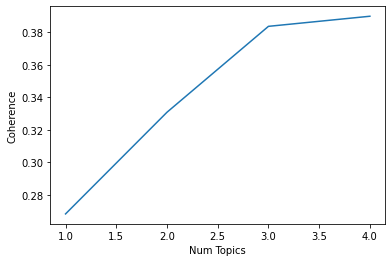

[(0,
  '0.021*"way" + 0.013*"also" + 0.013*"people" + 0.011*"live" + 0.009*"better" '
  '+ 0.008*"video" + 0.008*"able" + 0.008*"question" + 0.008*"others" + '
  '0.008*"get"'),
 (1,
  '0.030*"questions" + 0.020*"ask" + 0.017*"students" + 0.016*"able" + '
  '0.012*"get" + 0.010*"discuss" + 0.010*"feel" + 0.010*"knowledge" + '
  '0.010*"without" + 0.010*"chat"'),
 (2,
  '0.023*"discussion" + 0.023*"time" + 0.022*"get" + 0.014*"like" + '
  '0.013*"people" + 0.013*"better" + 0.012*"questions" + 0.010*"ask" + '
  '0.009*"understand" + 0.009*"chats"'),
 (3,
  '0.022*"time" + 0.016*"interactive" + 0.015*"interaction" + 0.015*"live" + '
  '0.015*"less" + 0.013*"face" + 0.013*"material" + 0.010*"peers" + '
  '0.010*"lecture" + 0.010*"active"')]


,Sentence_No,Dominant_Topic,Percent_Contribution,Keywords,Text
0,60,1.0,0.8674,"questions, ask, students, able, get, discuss, ...","Actually Im working on my thesis, so I work on..."
1,95,2.0,0.9052,"discussion, time, get, like, people, better, q...",More engaging and interesting
2,7,3.0,0.9410,"time, interactive, interaction, live, less, fa...","People are free to respond in their own time, ..."
3,93,3.0,0.8076,"time, interactive, interaction, live, less, fa...",Less pressure than online videos but also get ...


In [ ]:
i = 'chat'

why_for_i = df[df['preferred_mode'] == i]['why_mode']
optimal_model, columnwords, dictionary, corpus = optimalmodel(process_data(why_for_i), passes = 80, start = 1, stop = 5, step = 1)
df_why_mode = format_topics_sentences(optimal_model, corpus, why_for_i)
pprint(optimal_model.print_topics())
representative(df_why_mode)

## Why do you prefer online or in-person courses? 

### Why do you prefer in-person courses? <a name='inperson'></a>

There are optimally 4 topics


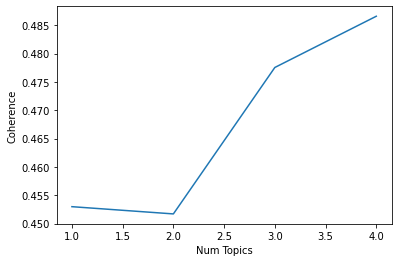

[(0,
  '0.053*"feel" + 0.051*"person" + 0.035*"like" + 0.032*"courses" + '
  '0.030*"engaging" + 0.027*"online" + 0.024*"face" + 0.023*"motivated" + '
  '0.016*"people" + 0.015*"learning"'),
 (1,
  '0.033*"people" + 0.033*"friends" + 0.028*"get" + 0.022*"see" + '
  '0.019*"social" + 0.018*"learn" + 0.017*"easier" + 0.017*"also" + '
  '0.017*"time" + 0.016*"interaction"'),
 (2,
  '0.039*"person" + 0.037*"easier" + 0.018*"better" + 0.016*"online" + '
  '0.015*"classes" + 0.014*"ask" + 0.014*"questions" + 0.013*"much" + '
  '0.012*"understand" + 0.011*"engage"'),
 (3,
  '0.033*"online" + 0.029*"person" + 0.021*"home" + 0.019*"learning" + '
  '0.018*"courses" + 0.017*"classes" + 0.016*"lectures" + 0.012*"university" + '
  '0.011*"study" + 0.011*"time"')]


,Sentence_No,Dominant_Topic,Percent_Contribution,Keywords,Text
0,4089,0.0,0.9855,"feel, person, like, courses, engaging, online,...",As I already said frontal lecturing works even...
1,4056,0.0,0.9684,"feel, person, like, courses, engaging, online,...",I seem to understand better with in person tea...
2,2000,0.0,0.9538,"feel, person, like, courses, engaging, online,...","I prefer to see my lecturer, have in class dis..."
3,4109,0.0,0.9518,"feel, person, like, courses, engaging, online,...",Because I shouldn’t be expected to pay such fe...
4,2945,0.0,0.9511,"feel, person, like, courses, engaging, online,...",Overall it’s more fair when it comes to evalua...
5,4047,1.0,0.9722,"people, friends, get, see, social, learn, easi...",Feedback is easily gathered
6,4066,1.0,0.9612,"people, friends, get, see, social, learn, easi...",Because I feel like I learn more and retain mu...
7,3512,1.0,0.9566,"people, friends, get, see, social, learn, easi...","Much more engagement, I can learn from others,..."
8,4079,1.0,0.9522,"people, friends, get, see, social, learn, easi...",It motivates me more to learn and it’s nice to...
9,4013,1.0,0.9518,"people, friends, get, see, social, learn, easi...",In-person courses mean that you are actually b...


In [ ]:
i = 'In-person Courses'

why_for_i = df[df['preference'] == i]['why_preference']
optimal_model, columnwords, dictionary, corpus = optimalmodel(process_data(why_for_i), passes = 80, start = 1, stop = 5, step = 1)
df_why_mode = format_topics_sentences(optimal_model, corpus, why_for_i)
pprint(optimal_model.print_topics())
representative(df_why_mode)

### Why do you prefer online courses? <a name='online'></a>

There are optimally 2 topics


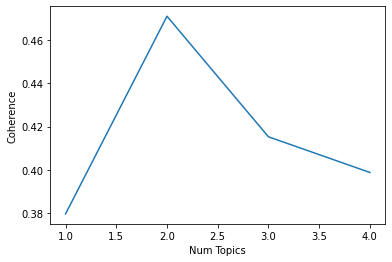

[(0,
  '0.053*"time" + 0.022*"online" + 0.021*"work" + 0.014*"lectures" + '
  '0.013*"classes" + 0.012*"get" + 0.012*"pace" + 0.011*"like" + 0.009*"home" '
  '+ 0.009*"go"'),
 (1,
  '0.037*"online" + 0.023*"courses" + 0.021*"person" + 0.015*"feel" + '
  '0.014*"classes" + 0.012*"less" + 0.011*"like" + 0.011*"prefer" + '
  '0.009*"better" + 0.009*"people"')]


,Sentence_No,Dominant_Topic,Percent_Contribution,Keywords,Text
0,222,0.0,0.9676,"time, online, work, lectures, classes, get, pa...",As a person with a disability (mental illness)...
1,291,0.0,0.9660,"time, online, work, lectures, classes, get, pa...",I can manage my own Time
2,425,0.0,0.9628,"time, online, work, lectures, classes, get, pa...",I can work at my own pace
3,126,0.0,0.9617,"time, online, work, lectures, classes, get, pa...",I can study during the time I study the best.
4,74,0.0,0.9605,"time, online, work, lectures, classes, get, pa...",Can rewind
5,3,1.0,0.9693,"online, courses, person, feel, classes, less, ...",Gives more freedom
6,655,1.0,0.9667,"online, courses, person, feel, classes, less, ...",I can make my own schedule and not waste time ...
7,636,1.0,0.9573,"online, courses, person, feel, classes, less, ...",i like them both
8,167,1.0,0.9408,"online, courses, person, feel, classes, less, ...",You can do it in your own time and if you miss...
9,114,1.0,0.9402,"online, courses, person, feel, classes, less, ...","No commute, better sleep schedule, spending mo..."


In [ ]:
i = 'Online Courses'

why_for_i = df[df['preference'] == i]['why_preference']
optimal_model, columnwords, dictionary, corpus = optimalmodel(process_data(why_for_i), passes = 80, start = 1, stop = 5, step = 1)
df_why_mode = format_topics_sentences(optimal_model, corpus, why_for_i)
pprint(optimal_model.print_topics())
representative(df_why_mode)

## If you could change one thing about the way your online classes are designed, what would you change? Why? <a name='remotechange'></a>

There are optimally 6 topics


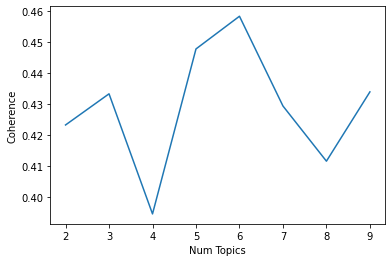

[(0,
  '0.058*"would" + 0.036*"make" + 0.030*"interactive" + 0.025*"like" + '
  '0.022*"classes" + 0.022*"engaging" + 0.021*"online" + 0.017*"live" + '
  '0.017*"lectures" + 0.016*"zoom"'),
 (1,
  '0.030*"classes" + 0.027*"online" + 0.026*"class" + 0.024*"groups" + '
  '0.024*"smaller" + 0.018*"would" + 0.018*"one" + 0.017*"better" + '
  '0.015*"people" + 0.014*"students"'),
 (2,
  '0.022*"nothing" + 0.020*"work" + 0.019*"change" + 0.018*"online" + '
  '0.016*"really" + 0.015*"assignments" + 0.014*"content" + 0.014*"think" + '
  '0.013*"learning" + 0.013*"anything"'),
 (3,
  '0.039*"questions" + 0.036*"live" + 0.030*"would" + 0.027*"ask" + '
  '0.027*"time" + 0.021*"classes" + 0.016*"hours" + 0.014*"lectures" + '
  '0.014*"class" + 0.013*"get"'),
 (4,
  '0.070*"lectures" + 0.048*"recorded" + 0.046*"live" + 0.031*"interaction" + '
  '0.030*"students" + 0.022*"would" + 0.018*"lecture" + 0.016*"content" + '
  '0.013*"instead" + 0.013*"pre"'),
 (5,
  '0.031*"would" + 0.020*"online" + 0.018

,Sentence_No,Dominant_Topic,Percent_Contribution,Keywords,Text
0,885,0.0,0.9664,"would, make, interactive, like, classes, engag...",Less use of videos - my Internet is bad and th...
1,2157,0.0,0.9600,"would, make, interactive, like, classes, engag...",Nothing
2,4600,0.0,0.9582,"would, make, interactive, like, classes, engag...",Less assignments! I feel like our school thoug...
3,1393,0.0,0.9580,"would, make, interactive, like, classes, engag...",I would do more activities in class so the stu...
4,842,0.0,0.9579,"would, make, interactive, like, classes, engag...",I would like a live feed of my lecturer as loo...
5,1789,1.0,0.9729,"classes, online, class, groups, smaller, would...",More structure and easier access of online res...
6,4086,1.0,0.9534,"classes, online, class, groups, smaller, would...",I'd like them to be more interactive.
7,1837,1.0,0.9533,"classes, online, class, groups, smaller, would...",Monologes with presentations from my prof are ...
8,1668,1.0,0.9506,"classes, online, class, groups, smaller, would...",For them to be consistent and to have activiti...
9,531,1.0,0.9505,"classes, online, class, groups, smaller, would...",They would include actual human interaction


In [ ]:
optimal_model, columnwords, dictionary, corpus = optimalmodel(columnlist[2], passes = 80, start = 2, stop = 10, step = 1)

df_remote_changes = format_topics_sentences(optimal_model, corpus, remote_changes)

pprint(optimal_model.print_topics())

representative(df_remote_changes)

## If you could change one thing about the way your in-person classes are designed, what would you change? Why? <a name='inpersonchange'></a>

There are optimally 5 topics


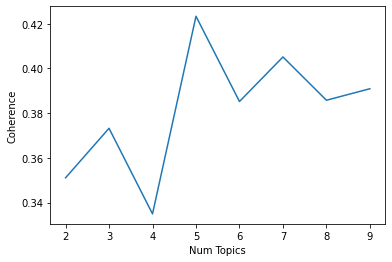

[(0,
  '0.048*"classes" + 0.025*"lectures" + 0.023*"interactive" + 0.020*"would" + '
  '0.017*"hours" + 0.016*"hour" + 0.016*"shorter" + 0.013*"make" + '
  '0.012*"long" + 0.011*"get"'),
 (1,
  '0.040*"change" + 0.034*"would" + 0.025*"think" + 0.021*"anything" + '
  '0.017*"engaging" + 0.016*"students" + 0.015*"learning" + 0.014*"teachers" + '
  '0.014*"interaction" + 0.013*"course"'),
 (2,
  '0.056*"smaller" + 0.041*"nothing" + 0.040*"questions" + 0.038*"people" + '
  '0.029*"classes" + 0.027*"groups" + 0.025*"class" + 0.024*"ask" + '
  '0.018*"would" + 0.017*"students"'),
 (3,
  '0.029*"time" + 0.026*"group" + 0.025*"less" + 0.021*"like" + 0.020*"work" + '
  '0.020*"would" + 0.019*"discussion" + 0.017*"small" + 0.015*"lectures" + '
  '0.014*"class"'),
 (4,
  '0.035*"lectures" + 0.024*"would" + 0.021*"class" + 0.018*"lecture" + '
  '0.017*"online" + 0.014*"recorded" + 0.011*"like" + 0.011*"time" + '
  '0.010*"person" + 0.010*"hours"')]


,Sentence_No,Dominant_Topic,Percent_Contribution,Keywords,Text
0,521,0.0,0.9612,"classes, lectures, interactive, would, hours, ...",smaller classes/ more TAs to ask questions
1,911,0.0,0.9541,"classes, lectures, interactive, would, hours, ...",Given the resources lecturers use so we can fo...
2,2374,0.0,0.9491,"classes, lectures, interactive, would, hours, ...",More contact hours
3,434,0.0,0.9491,"classes, lectures, interactive, would, hours, ...",More individual focus and creative learning ex...
4,852,0.0,0.9456,"classes, lectures, interactive, would, hours, ...","Nothing, love them:)"
5,1722,1.0,0.9803,"change, would, think, anything, engaging, stud...",Be quizzed during the in-person classes - it w...
6,992,1.0,0.9755,"change, would, think, anything, engaging, stud...",The length they are far to short for the topic...
7,2952,1.0,0.9740,"change, would, think, anything, engaging, stud...",More practicality as it is quite boring and di...
8,195,1.0,0.9686,"change, would, think, anything, engaging, stud...",Smaller groups
9,1930,1.0,0.9591,"change, would, think, anything, engaging, stud...",Being able to view slides beforehand


In [ ]:
optimal_model, columnwords, dictionary, corpus = optimalmodel(columnlist[3], passes = 80, start = 2, stop = 10, step = 1)

df_prior_changes = format_topics_sentences(optimal_model, corpus, prior_changes)

pprint(optimal_model.print_topics())

representative(df_prior_changes)